In [2]:
import norse
import torch

## Encoding

If we want to do computation with spiking neurons, the first question to ask ourselves is how to encode data (images, video, audio, text, etc.) into spikes. We can approach this problem from either a purely practical perspective or be guided by what is known from biological nervous systems. Biological nervous systems also process additional sensory modalities which aren't typically considered in the machine learning literature, such as smell, touch, etc.

In Norse we operate primarily on tensors of data, irrespective of the origin of this data. For
example an image naturally is encoded as a tensor with shape (C, W, H), where C is the number
channels (colors), W is the width and H is the height of the image. 



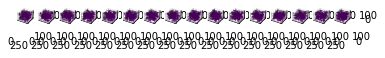

In [38]:
import matplotlib.pyplot as plt

z = norse.functional.encode.poisson_encode(0.001 * torch.ones(16, 128, 128), seq_length=256)


def plot_spikes_2d(fig, z):
    channels = z.shape[1]

    for c in range(channels):
        ax = fig.add_subplot(1, channels, c+1, projection='3d')
        s = z[:,c].detach().to_sparse()
        ax.scatter(s.indices()[0], s.indices()[1], s.indices()[2], s=0.1, c=s.values())

fig = plt.figure()

plot_spikes_2d(fig, z)

### Image Data

In [6]:
import torchvision

batch_size = 32

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        # torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

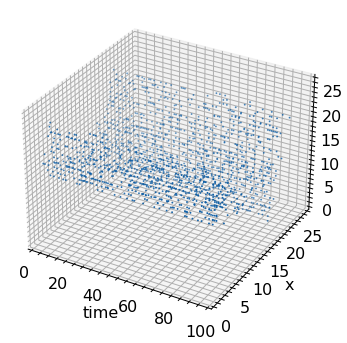

In [12]:
img, label = train_data[2]

T = 100
z = norse.functional.encode.poisson_encode(2.0 * img.squeeze(0), seq_length=T)
z = z.to_sparse()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z.indices()[0], z.indices()[2], 28-z.indices()[1], s=0.8)
ax.set_xlabel('time')
ax.set_ylabel('x')
ax.set_xlim([0,T])
ax.set_ylim([0,27])
ax.set_zlim([0,27])

fig.show()

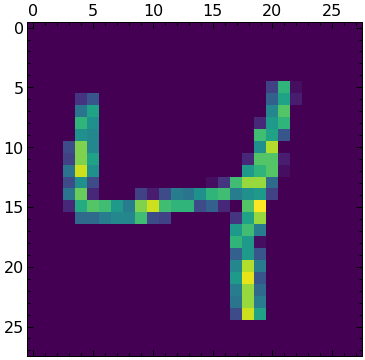

In [11]:
plt.matshow(torch.sum(z.to_dense(), axis=0) / T)

torch.Size([16, 28, 28])


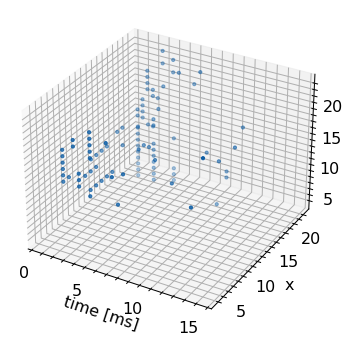

In [23]:
img, label = train_data[2]

T = 16
z = norse.functional.encode.spike_latency_lif_encode(4.0*img.squeeze(0), seq_length=T)
print(z.shape)
z = z.to_sparse().coalesce()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z.indices()[0], z.indices()[2], 28-z.indices()[1], s=10.0)
ax.set_xlim([0, T])
ax.set_xlabel('time [ms]')
ax.set_ylabel('x')
ax.set_zlabel('')

fig.show()



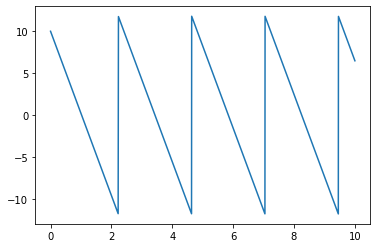

In [33]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

big_number = 10000.0
width = 0.0001

ts = np.linspace(0, 10, 2000)
def f(X, t):
    dx0 = X[1]
    dx1 = -9.8
    dx1 += big_number / (1 + np.exp(X[0]/width))
    return [dx0, dx1]

with np.errstate(over='ignore'):
    # don't print overflow warning messages from exp(),
    # and limit the step size so that the solver doesn't step too deep
    # into the forbidden region
    X = odeint(f, [2, 10], ts, hmax=0.01)
plt.plot(ts, X[:, 1])
plt.show()